# Import Libs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *

%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'


# some stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.2 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 161MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=12b9032a00ce43f9132941a5b56ff58af17de9105302d5fbe40a193102859d21
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstal

# 1 - Data Preparation and EDA


## 1.1 Data Retrieval and Cleaning

###1.1.1 Symbols and actual companies 'BG','LW','WMT','AMT','HST','BXP','AWK','EIX','ES']
######BG = Bunge Limited
######LW = Lamb weston
######WMT = Walmart
######AMT = American tower
######HST = Host hotel&resorts
######BXP = Boston property
######AWK = American Water Works
######EIX = Edison international
######ES = Eversource

In [ ]:
# Assign the ticker list that we want to scrap
# Three sectors: 1st:Consumer Staples Sector, 2nd:Real Estate Sector, 3rd:Utility Sector
tickers_list = ['BG','LW','WMT','AMT','HST','BXP','AWK','EIX','ES']

# Using dictionary comprehenstion pull historical price data for each stocks to match with our news score later, https://www.datacamp.com/tutorial/python-dictionary-comprehension
# Market didn't open January 1, 2017, so our start date is January 2, 2017
dow_prices = {ticker : si.get_data(ticker,start_date = '01/02/2017',end_date='12/31/2021',interval='1d') for ticker in tickers_list}

# syntax {key: value for (key, value) in iterable}
# alternative way using for loop to store data in a list
# dow_prices = {}
# for ticker in tickers_list:
#   dow_prices[ticker] = si.get_data(ticker,start_date = '01/01/2020',end_date='04/07/2023',interval='1d')

In [ ]:
# take a peek!
dow_prices

{'BG':                  open       high        low      close   adjclose   volume  \
 2017-01-03  72.860001  73.269997  72.290001  73.239998  58.757500   650500   
 2017-01-04  73.309998  73.400002  71.889999  72.269997  57.979298  1001900   
 2017-01-05  72.349998  72.480003  70.900002  71.099998  57.040672   874000   
 2017-01-06  70.919998  70.989998  69.879997  70.139999  56.270508   912000   
 2017-01-09  69.980003  70.930000  69.940002  70.139999  56.270508   709300   
 ...               ...        ...        ...        ...        ...      ...   
 2021-12-23  89.010002  90.400002  88.800003  90.160004  84.760490   481200   
 2021-12-27  90.269997  91.290001  89.559998  91.059998  85.606583   366800   
 2021-12-28  90.839996  91.760002  90.550003  91.730003  86.236473   456000   
 2021-12-29  91.800003  92.449997  91.419998  92.209999  86.687721   482500   
 2021-12-30  92.510002  93.230003  91.849998  92.059998  86.546700   411300   
 
            ticker  
 2017-01-03     BG  
 2

### 1.1.2 Retrieve the adjusted closing price

In [ ]:
# let's extract just the data we need (adjclose)
# get the adjclose price for the BG (one sample)
prep_data = pd.DataFrame(dow_prices['BG']['adjclose']).rename(columns = {"adjclose":"BG"})

# combine all the tickers (all the rest of the samples)
for i in tickers_list[0:]:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])
prep_data

,BG,LW,WMT,AMT,HST,BXP,AWK,EIX,ES
2017-01-03,58.757500,33.930641,19.917543,89.910622,14.919605,95.094383,62.981483,53.448414,43.324253
2017-01-04,57.979298,33.469070,20.033579,90.071564,15.083386,98.115181,63.469673,53.902805,43.473705
2017-01-05,57.040672,33.143250,20.077087,89.758179,14.428267,98.586250,63.574276,53.709137,43.481571
2017-01-06,56.270508,33.333305,19.801506,89.165253,14.233288,98.361931,63.495804,53.403732,43.465832
2017-01-09,56.270508,33.387604,19.932047,88.953499,14.194295,97.382401,62.196960,52.904606,42.923103
...,...,...,...,...,...,...,...,...,...
2021-12-23,84.760490,59.778393,44.781288,260.319153,15.802082,99.608765,173.475723,60.652523,81.471451
2021-12-27,85.606583,59.778393,45.189007,266.875214,15.920484,101.038460,174.904861,60.607716,81.271065
2021-12-28,86.236473,60.233387,45.837502,269.424774,15.920484,100.524109,177.343872,61.127560,82.036217
2021-12-29,86.687721,60.659340,45.815025,269.789062,15.920484,100.759491,178.534836,61.342682,82.537224


In [ ]:
prep_data.shape

(1258, 9)

In [ ]:
prep_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2017-01-03 to 2021-12-30
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BG      1258 non-null   float64
 1   LW      1258 non-null   float64
 2   WMT     1258 non-null   float64
 3   AMT     1258 non-null   float64
 4   HST     1258 non-null   float64
 5   BXP     1258 non-null   float64
 6   AWK     1258 non-null   float64
 7   EIX     1258 non-null   float64
 8   ES      1258 non-null   float64
dtypes: float64(9)
memory usage: 98.3 KB


### 1.1.3 Percent change table and drop null values

In [ ]:
# create return features for each ticker
# we will just use a pct_change as the return
return_data = pd.DataFrame()
for i in tickers_list:
  return_data[i] = prep_data[i].pct_change()
# drop the na records
return_data.dropna(inplace=True)

In [ ]:
# 1 record was dropped
return_data.shape

(1257, 9)

In [ ]:
# look left, it should dump out... click Folder Icon
# return_data.to_csv('GROUP3_porfolioAllocation.csv')

Try to visualize it but it is too dense by day, so the time seriese visualization should be done by month in order to have clear look

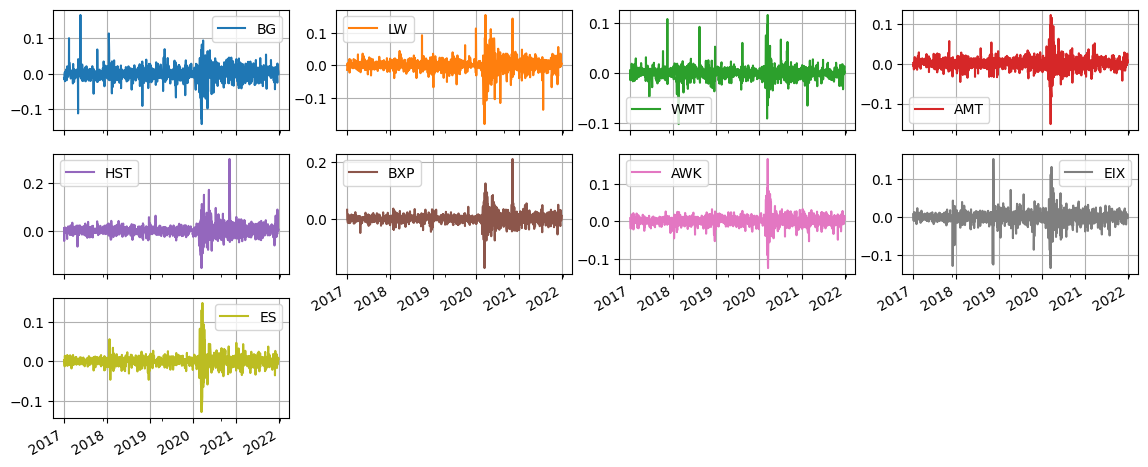

In [ ]:
# plot the trend by day
return_data.plot(subplots=True,
        grid=True,
        layout=(3,4),
        figsize=(14,6))
plt.show()

## 1.2 Time Series Visualizations by Month
It's running the same code except for interval by 1mo






In [ ]:
# Assign the ticker list that we want to scrap
# three sectors:
tickers_list = ['BG','LW','WMT','AMT','HST','BXP','AWK','EIX','ES']

# using dictionary comprehenstion pull historical price data for each stocks to match with our news score later, https://www.datacamp.com/tutorial/python-dictionary-comprehension
dow_prices_mo = {ticker : si.get_data(ticker,start_date = '01/02/2017',end_date='12/31/2021',interval='1mo') for ticker in tickers_list}

# get the adjclose price for the BG (one sample)
prep_data_mo = pd.DataFrame(dow_prices_mo['BG']['adjclose']).rename(columns = {"adjclose":"BG"})
prep_data_mo

# combine all the tickers (all the rest of the samples)
for i in tickers_list[1:]:
  prep_data_mo[i] = pd.DataFrame(dow_prices_mo[i]['adjclose'])

# create return features for each ticker
# we will just use a pct_change as the return
return_data_mo = pd.DataFrame()
for i in tickers_list:
  return_data_mo[i] = prep_data_mo[i].pct_change()
# drop the na records
return_data_mo.dropna(inplace=True)
return_data_mo.head()

,BG,LW,WMT,AMT,HST,BXP,AWK,EIX,ES
2017-02-01,0.182632,0.054388,0.062781,0.109083,-0.004427,0.062108,0.062092,0.094128,0.060376
2017-03-01,-0.025666,0.073233,0.016214,0.058803,0.037243,-0.047616,0.002200,-0.001630,0.010217
2017-04-01,-0.002902,-0.007370,0.050677,0.036202,-0.027343,-0.038387,0.025589,0.011310,0.010548
2017-05-01,0.011894,0.116560,0.045491,0.047002,0.002228,-0.041706,-0.019810,0.020007,0.044949
2017-06-01,-0.061520,-0.051066,-0.030707,0.008614,0.015564,0.014012,0.002316,-0.041437,-0.014340


### 1.2.1 Visualization of Consumer Staples Sector

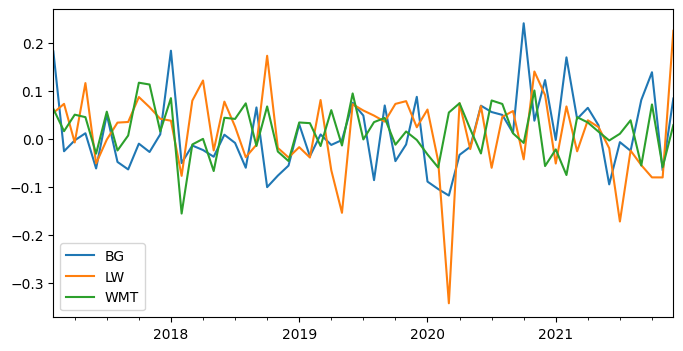

In [ ]:
# plot the trend, better!
cs = return_data_mo[['BG','LW','WMT']]
cs.plot(
        figsize=(8,4))
plt.show()

### 1.2.2 Visualization of Real Estate Sector

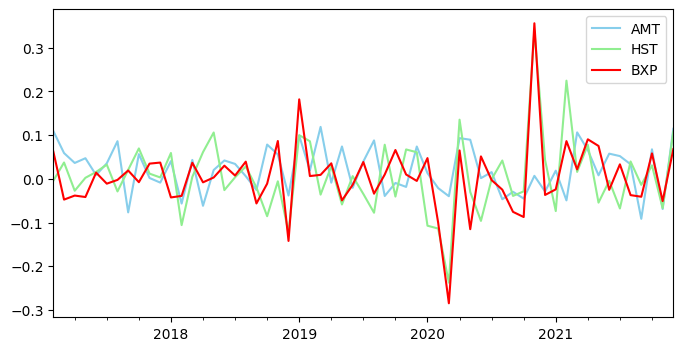

In [ ]:
# plot the trend
re = return_data_mo[['AMT','HST','BXP']]
re.plot(color =('skyblue','lightgreen','red'),
        figsize=(8,4))
plt.show()


### 1.2.3 Visualization of Utility Sector

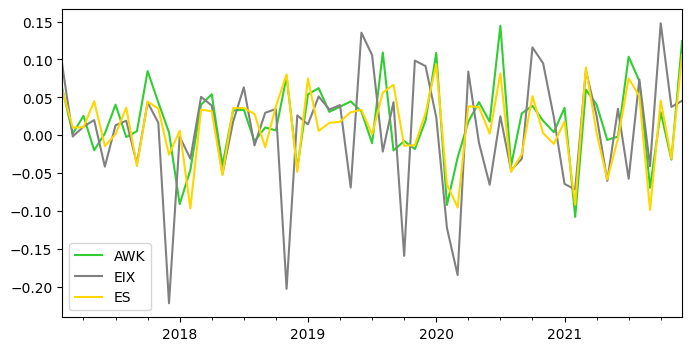

In [ ]:
# plot the trend
u = return_data_mo[['AWK','EIX','ES']]
u.plot(color =('limegreen','grey','gold'),
        figsize=(8,4))
plt.show()

### 1.2.4 Visualization of all 9 stock by month

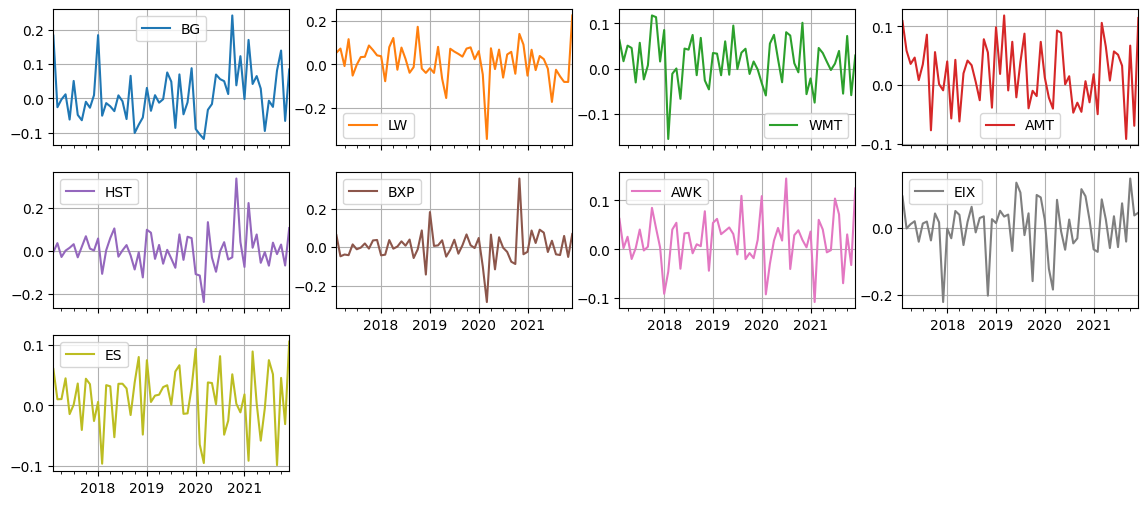

In [ ]:
# plot the trend by month
return_data_mo.plot(subplots=True,
        grid=True,
        layout=(3,4),
        figsize=(14,6))
plt.show()

## 1.3 - Discussion of the Plots

### 1.3.1 Insight from Consumer Staples Sector

In [ ]:
# Pull the max, min, mean, and std_dev
Max_Return = pd.DataFrame(cs.max().values.reshape(1, -1), columns=cs.columns).rename(index={0: "Max_Return"})
print(Max_Return)

Min_Return = pd.DataFrame(cs.min().values.reshape(1, -1), columns=cs.columns).rename(index={0: "Min_Return"})
print(Min_Return)

Avg_Return = pd.DataFrame(cs.mean().values.reshape(1, -1), columns=cs.columns).rename(index={0: "Avg_Return"})
print(Avg_Return)

Std_Dev_Return = pd.DataFrame(cs.std().values.reshape(1, -1), columns=cs.columns).rename(index={0: "Std_Dev_Return"})
print(Std_Dev_Return)

# Discussion:
# WMT appears to have the most stable returns with a higher average return
# while BG has the highest maximum return but also a relatively higher standard deviation.
# LW shows the highest minimum return and the highest volatility, indicating potential risks associated with investing in that asset.

                  BG        LW       WMT
Max_Return  0.241357  0.225708  0.117353
                  BG        LW       WMT
Min_Return -0.118077 -0.342847 -0.155629
                  BG       LW       WMT
Avg_Return  0.010566  0.01416  0.016241
                      BG        LW       WMT
Std_Dev_Return  0.076804  0.087123  0.052617


### 1.3.2 Insight from Real Estate Sector

In [ ]:
# pull the max, min, mean, and std_dev
Max_Return = pd.DataFrame(re.max().values.reshape(1, -1), columns=cs.columns).rename(index={0: "Max_Return"})
print(Max_Return)

Min_Return = pd.DataFrame(re.min().values.reshape(1, -1), columns=cs.columns).rename(index={0: "Min_Return"})
print(Min_Return)

Avg_Return = pd.DataFrame(re.mean().values.reshape(1, -1), columns=cs.columns).rename(index={0: "Avg_Return"})
print(Avg_Return)

Std_Dev_Return = pd.DataFrame(re.std().values.reshape(1, -1), columns=cs.columns).rename(index={0: "Std_Dev_Return"})
print(Std_Dev_Return)

# Discussion:
# HST has the highest standard deviation of returns (0.085011), followed by BXP (0.081015) and AMT (0.052855).
# This suggests that HST and BXP have higher volatility and potentially greater fluctuations in returns compared to AMT.
# Investors with a lower risk tolerance may prefer stocks with lower standard deviations.

                  BG        LW       WMT
Max_Return  0.118706  0.338741  0.355614
                  BG        LW       WMT
Min_Return -0.091591 -0.237569 -0.284706
                  BG        LW       WMT
Avg_Return  0.020739  0.005479  0.003681
                      BG        LW       WMT
Std_Dev_Return  0.053309  0.085741  0.081711


### 1.3.3 Insight from Utility Sector

In [ ]:
# pull the max, min, mean, and std_dev
# Pull the max, min, mean, and std_dev
Max_Return = pd.DataFrame(u.max().values.reshape(1, -1), columns=cs.columns).rename(index={0: "Max_Return"})
print(Max_Return)

Min_Return = pd.DataFrame(u.min().values.reshape(1, -1), columns=cs.columns).rename(index={0: "Min_Return"})
print(Min_Return)

Avg_Return = pd.DataFrame(u.mean().values.reshape(1, -1), columns=cs.columns).rename(index={0: "Avg_Return"})
print(Avg_Return)

Std_Dev_Return = pd.DataFrame(u.std().values.reshape(1, -1), columns=cs.columns).rename(index={0: "Std_Dev_Return"})
print(Std_Dev_Return)

# Discussion:
# EIX has the highest maximum return and the highest minimum return, suggesting potential for significant gains but also higher volatility and risk.
# AWK has the highest average return and the lowest standard deviation, indicating more consistent positive performance with lower volatility.
# ES has a relatively moderate maximum return and a lower standard deviation, suggesting a balanced level of return and volatility.

                  BG       LW       WMT
Max_Return  0.144645  0.14781  0.105871
                  BG        LW       WMT
Min_Return -0.107785 -0.221853 -0.098865
                  BG        LW       WMT
Avg_Return  0.018942  0.005148  0.012054
                      BG        LW       WMT
Std_Dev_Return  0.051186  0.077698  0.049037


# 2 - Optimization Model



2.0.1- A way that we can balance our portfolio is to look at how different stocks vary ith each other.



In [ ]:
# here's the covariance matrix
Covariance_matrix = return_data_mo.cov()
Covariance_matrix

,BG,LW,WMT,AMT,HST,BXP,AWK,EIX,ES
BG,0.005899,0.001301,0.000541,0.000026,0.002508,0.001246,-0.000181,0.002197,0.000412
LW,0.001301,0.007590,0.000837,0.000925,0.003506,0.003377,0.000418,0.002174,0.001134
WMT,0.000541,0.000837,0.002769,0.000941,0.001303,0.000875,0.000992,0.001381,0.001202
AMT,0.000026,0.000925,0.000941,0.002842,0.000481,0.001102,0.001344,0.001000,0.001685
HST,0.002508,0.003506,0.001303,0.000481,0.007351,0.004817,0.000005,0.002329,0.000575
BXP,0.001246,0.003377,0.000875,0.001102,0.004817,0.006677,0.000954,0.001235,0.001209
AWK,-0.000181,0.000418,0.000992,0.001344,0.000005,0.000954,0.002620,0.000959,0.001975
EIX,0.002197,0.002174,0.001381,0.001000,0.002329,0.001235,0.000959,0.006037,0.001568
ES,0.000412,0.001134,0.001202,0.001685,0.000575,0.001209,0.001975,0.001568,0.002405


2.0.2- And here is the correlation matrix.

In [ ]:
# correlation matrix of 9 stocks
Corr_matrix = return_data_mo.corr()
Corr_matrix

,BG,LW,WMT,AMT,HST,BXP,AWK,EIX,ES
BG,1.000000,0.194401,0.133859,0.006330,0.380830,0.198555,-0.046074,0.368133,0.109447
LW,0.194401,1.000000,0.182539,0.199200,0.469333,0.474405,0.093702,0.321176,0.265332
WMT,0.133859,0.182539,1.000000,0.335611,0.288807,0.203446,0.368281,0.337859,0.465761
AMT,0.006330,0.199200,0.335611,1.000000,0.105211,0.252976,0.492640,0.241399,0.644733
HST,0.380830,0.469333,0.288807,0.105211,1.000000,0.687540,0.001112,0.349548,0.136695
BXP,0.198555,0.474405,0.203446,0.252976,0.687540,1.000000,0.228005,0.194572,0.301663
AWK,-0.046074,0.093702,0.368281,0.492640,0.001112,0.228005,1.000000,0.241162,0.786879
EIX,0.368133,0.321176,0.337859,0.241399,0.349548,0.194572,0.241162,1.000000,0.411627
ES,0.109447,0.265332,0.465761,0.644733,0.136695,0.301663,0.786879,0.411627,1.000000


In [ ]:
# creating covariance table on stock return dataframe
df_cov = return_data_mo.cov()
print('Covariance Matrix:')
print(df_cov)
print('\n') # return/blank line

# create the average of each stock
# these are the objective function COEFFICIENTS!
df_return = return_data_mo.mean()
print('Average Return:')
print(df_return)

Covariance Matrix:
           BG        LW       WMT       AMT       HST       BXP       AWK  \
BG   0.005899  0.001301  0.000541  0.000026  0.002508  0.001246 -0.000181   
LW   0.001301  0.007590  0.000837  0.000925  0.003506  0.003377  0.000418   
WMT  0.000541  0.000837  0.002769  0.000941  0.001303  0.000875  0.000992   
AMT  0.000026  0.000925  0.000941  0.002842  0.000481  0.001102  0.001344   
HST  0.002508  0.003506  0.001303  0.000481  0.007351  0.004817  0.000005   
BXP  0.001246  0.003377  0.000875  0.001102  0.004817  0.006677  0.000954   
AWK -0.000181  0.000418  0.000992  0.001344  0.000005  0.000954  0.002620   
EIX  0.002197  0.002174  0.001381  0.001000  0.002329  0.001235  0.000959   
ES   0.000412  0.001134  0.001202  0.001685  0.000575  0.001209  0.001975   

          EIX        ES  
BG   0.002197  0.000412  
LW   0.002174  0.001134  
WMT  0.001381  0.001202  
AMT  0.001000  0.001685  
HST  0.002329  0.000575  
BXP  0.001235  0.001209  
AWK  0.000959  0.001975  
EI

## 2.1 Model execution

In [ ]:
from pyomo.environ import *
m = ConcreteModel()

# defining variables 'BG','LW','WMT','AMT','HST','BXP','AWK','EIX','ES'
m.BG = Var(within=NonNegativeReals, bounds=(0,1))
m.LW = Var(within=NonNegativeReals, bounds=(0,1))
m.WMT = Var(within=NonNegativeReals, bounds=(0,1))
m.AMT = Var(within=NonNegativeReals, bounds=(0,1))
m.HST = Var(within=NonNegativeReals, bounds=(0,1))
m.BXP = Var(within=NonNegativeReals, bounds=(0,1))
m.AWK = Var(within=NonNegativeReals, bounds=(0,1))
m.EIX = Var(within=NonNegativeReals, bounds=(0,1))
m.ES = Var(within=NonNegativeReals, bounds=(0,1))

# BINARY variables added
m.BGy = Var(domain=Binary)
m.LWy = Var(domain=Binary)
m.WMTy = Var(domain=Binary)
m.AMTy = Var(domain=Binary)
m.HSTy = Var(domain=Binary)
m.BXPy = Var(domain=Binary)
m.AWKy = Var(domain=Binary)
m.EIXy = Var(domain=Binary)
m.ESy = Var(domain=Binary)

In [ ]:
# Only select one from each sector
m.c1= Constraint(expr= m.BGy + m.LWy + m.WMTy == 1 )
m.c2= Constraint(expr= m.AMTy + m.BXPy + m.HSTy == 1 )
m.c3= Constraint(expr= m.AWKy + m.EIXy + m.ESy == 1 )

In [ ]:
# LINKING CONSTRAINTS, which can help us decide if we should even invest in this stock
m.link1 = Constraint(expr = m.BG - 1*m.BGy <= 0)
m.link2 = Constraint(expr = m.LW - 1*m.LWy <= 0)
m.link3 = Constraint(expr = m.WMT - 1*m.WMTy <= 0)
m.link4 = Constraint(expr = m.AMT - 1*m.AMTy <= 0)
m.link5 = Constraint(expr = m.HST - 1*m.HSTy <= 0)
m.link6 = Constraint(expr = m.BXP - 1*m.BXPy <= 0)
m.link7 = Constraint(expr = m.AWK - 1*m.AWKy <= 0)
m.link8 = Constraint(expr = m.EIX - 1*m.EIXy <= 0)
m.link9 = Constraint(expr = m.ES - 1*m.ESy <= 0)

In [ ]:
# declare objective
# if you wanted to be even cleaner, you could put this into a dictionary...
m.objective = Objective(expr =
                        m.BGy*m.BG*df_return[0] +
                        m.LWy*m.LW*df_return[1] +
                        m.WMTy*m.WMT*df_return[2] +
                        m.AMTy*m.AMT*df_return[3] +
                        m.HSTy*m.HST*df_return[4]+
                        m.BXPy*m.BXP*df_return[5] +
                        m.AWKy*m.AWK*df_return[6] +
                        m.EIXy*m.EIX*df_return[7] +
                        m.ESy*m.ES*df_return[8],
                        sense=maximize) # yes, we want to MAX our returns!

# declare constraints
# Sum of all proportions = 1
m.sum_proportions = Constraint(expr = m.BG + m.LW + m.WMT + m.AMT + m.HST + m.BXP + m.AWK + m.EIX + m.ES == 1)

# Set minimum risk: WE ARE INCLUDING THIS CONSTRAINT NOW FOR TECHNICAL REASONS (see below)
# It is just initializing the constraint
m.total_risk = Constraint(expr = m.BG + m.LW + m.WMT + m.AMT + m.HST + m.BXP + m.AWK + m.EIX + m.ES >= 0.0)

In [ ]:
# creating calculations table for calculate the risk
# 3. Calculate risk
def calc_risk(m):
  variables = m.BG, m.LW , m.WMT , m.AMT , m.HST , m.BXP , m.AWK , m.EIX , m.ES
  tickers = ['BG','LW','WMT','AMT','HST','BXP','AWK','EIX','ES']
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*df_cov.at[tickers[i],tickers[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(m)

# Max risk should be less than 0.01
max_risk = 0.0035
# Sequence of risk levels
risk_limits = np.arange(0.0012, max_risk, 0.00001) # take tiny steps
# checking number risk levels, minmum number of level- 100
num_elements = risk_limits.size
print(num_elements)

230


In [ ]:
# PROFESSOR'S CODE SNIPPET

from pyomo.opt import SolverStatus, TerminationCondition

# updating risk contraint for each limit and then solving the problem
param_analysis = {} # key=risk, value =stock allocations
returns = {} # key=risk, value = return
for r in risk_limits:

  # Remove constraint to avoid error messages
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)

 # Run solver
  solver = SolverFactory('ipopt', executable=ipopt_executable)
  result = solver.solve(m)

  # MAY NOT FILTER ALL INFEASIBLE OUTCOMES IN REAL-WORLD INSTANCES
  # # If solution is not feasible, ignore this run
  # if result.solver.termination_condition == TerminationCondition.infeasible:
  #   continue

  # If solution is not feasible, ignore this run
  if result.solver.termination_condition != TerminationCondition.optimal:
    continue
  result = result.write()

  # store our allocation proportions
  param_analysis[r] = [m.BG(), m.LW() , m.WMT() , m.AMT() , m.HST() , m.BXP() , m.AWK() , m.EIX() , m.ES()]
  # store our returns
  returns[r] =  m.BG()*df_return[0] + m.LW()*df_return[1] + m.WMT()*df_return[2] +m.AMT()*df_return[3] + m.HST()*df_return[4]+m.BXP()*df_return[5] + m.AWK()*df_return[6] + m.EIX()*df_return[7] + m.ES()*df_return[8]

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem ma

Streaming output truncated to the last 5000 lines.
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.017910003662109375
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 14
  Number of variables: 18
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ---------------------

## 2.2 Plot with allocation of the stocks

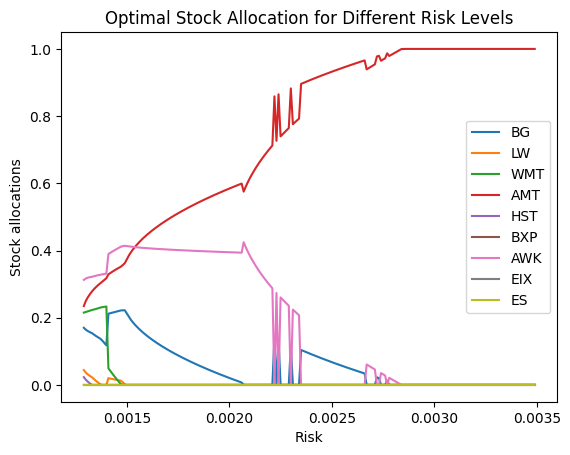

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns =  ['BG','LW','WMT','AMT','HST','BXP','AWK','EIX','ES']
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
xlabel('Risk')
ylabel('Stock allocations')
plt.show()

## 2.3 Plot with efficient frontier

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

[0.0012900000000000001, 0.0013000000000000002, 0.0013100000000000002, 0.0013200000000000002, 0.0013300000000000002, 0.0013400000000000003, 0.0013500000000000003, 0.0013600000000000003, 0.0013700000000000003, 0.0013800000000000004, 0.0013900000000000004, 0.0014000000000000004, 0.0014100000000000004, 0.0014200000000000005, 0.0014300000000000005, 0.0014400000000000005, 0.0014500000000000006, 0.0014600000000000006, 0.0014700000000000006, 0.0014800000000000006, 0.0014900000000000007, 0.0015000000000000007, 0.0015100000000000007, 0.0015200000000000007, 0.0015300000000000008, 0.0015400000000000008, 0.0015500000000000008, 0.0015600000000000008, 0.0015700000000000009, 0.0015800000000000009, 0.001590000000000001, 0.001600000000000001, 0.001610000000000001, 0.001620000000000001, 0.001630000000000001, 0.001640000000000001, 0.001650000000000001, 0.001660000000000001, 0.0016700000000000011, 0.0016800000000000012, 0.0016900000000000012, 0.0017000000000000012, 0.0017100000000000012, 0.0017200000000000

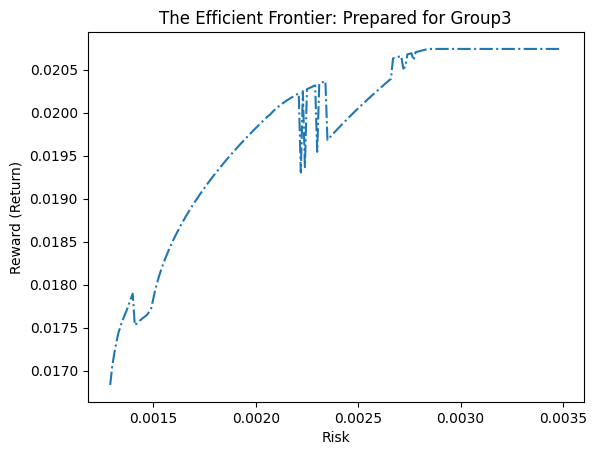

In [ ]:
# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier: Prepared for Group3')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

## 2.4 Portfolio selection

In [ ]:
# creating calculations table for calculate the risk
# Calculate risk
def calc_risk(m):
  variables = m.BG, m.LW , m.WMT , m.AMT , m.HST , m.BXP , m.AWK , m.EIX , m.ES
  tickers = ['BG','LW','WMT','AMT','HST','BXP','AWK','EIX','ES']
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*df_cov.at[tickers[i],tickers[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(m)

# Max risk should be less than 0.01
max_risk = 0.00155

# Sequence of risk levels
risk_limits = np.arange(0.0015, max_risk, 0.00001) # take tiny steps
risk_limits

array([0.0015 , 0.00151, 0.00152, 0.00153, 0.00154])

In [ ]:
# checking number risk levels, minmum number of level- 100
num_elements = risk_limits.size
print(num_elements)

5


In [ ]:
from pyomo.opt import SolverStatus, TerminationCondition

# updating risk contraint for each limit and then solving the problem
param_analysis = {} # key=risk, value =stock allocations
returns = {} # key=risk, value = return
for r in risk_limits:

  # Remove constraint to avoid error messages
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)

  # run solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m)
  # MAY NOT FILTER ALL INFEASIBLE OUTCOMES IN REAL-WORLD INSTANCES
  # If solution is not feasible, ignore this run
  # if result.solver.termination_condition == TerminationCondition.infeasible:
  # continue

  # If solution is not feasible, ignore this run
  if result.solver.termination_condition != TerminationCondition.optimal:
    continue
  result = result.write()

  # store our allocation proportions
  param_analysis[r] = [m.BG(), m.LW() , m.WMT() , m.AMT() , m.HST() , m.BXP() , m.AWK() , m.EIX() , m.ES()]
  # store our returns
  returns[r] =  m.BG()*df_return[0] + m.LW()*df_return[1] + m.WMT()*df_return[2] +m.AMT()*df_return[3] + m.HST()*df_return[4]+m.BXP()*df_return[5] + m.AWK()*df_return[6] + m.EIX()*df_return[7] + m.ES()*df_return[8]

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 14
  Number of variables: 18
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.023448944091796875
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ==

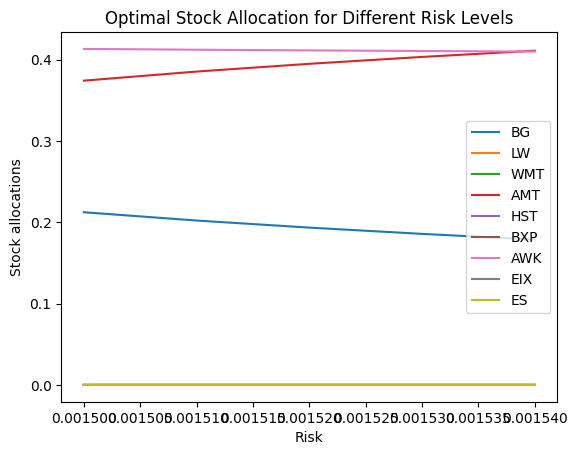

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns =  ['BG','LW','WMT','AMT','HST','BXP','AWK','EIX','ES']
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
xlabel('Risk')
ylabel('Stock allocations')
plt.show()

[0.0015, 0.00151, 0.00152, 0.0015300000000000001, 0.0015400000000000001]
[0.017835298523407154, 0.017940857516525258, 0.018030869935791793, 0.018110668086858735, 0.01818309966138969]


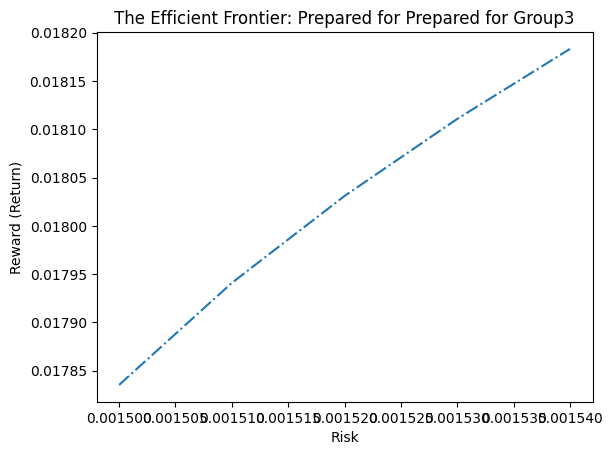

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier: Prepared for Prepared for Group3')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

In [ ]:
# check which stocks are selected by the model
print('obj=',m.objective())
print("Bunge Limited = ", m.BGy())
print("Lamb weston = ", m.LWy())
print("Walmart = ", m.WMTy())
print("American tower = ", m.AMTy())
print("Host hotel&resorts = ", m.HSTy())
print("Boston property = ", m.BXPy())
print("American Water Works= ", m.AWKy())
print("Edison international = ", m.EIXy())
print("Eversource = ", m.ESy())
# We include BG, AMT, AWK in our portfolio as they are really close to 1

obj= 0.01818304765258214
Bunge Limited =  0.9999932302021171
Lamb weston =  3.3575616548417634e-06
Walmart =  3.412236228179536e-06
American tower =  0.9999983639525128
Host hotel&resorts =  8.469979978410554e-07
Boston property =  7.890494893099986e-07
American Water Works=  0.9999982991328442
Edison international =  8.605938640837957e-07
Eversource =  8.402732917533067e-07


In [ ]:
# check the result of our allocation
print('obj=',m.objective())
print("Bunge Limited = ", m.BG())
print("American tower = ", m.AMT())
print("American Water Works= ", m.AWK())
portfolio = m.BG()+m.AMT()+m.AWK()
print('BG + AMT + AWK=',portfolio)

obj= 0.01818304765258214
Bunge Limited =  0.17880173812827638
American tower =  0.41112467056864077
American Water Works=  0.41007240881257023
BG + AMT + AWK= 0.9999988175094874


# 3 - Analysis

## 3.1 - Buy-and-Hold strategy for the MPT portfolio
#### to simplify the portfolio, we will use allocate our portforlio as follows:
#### BG = 0.179
#### AMT = 0.411
#### AWK = 0.41


In [ ]:
# three sectors: 1st:Consumer Staples, 2nd:Real Estate. 3rd:Utility
tickers_BAH = ['BG','AMT','AWK']
dow_prices = {ticker : si.get_data(ticker,start_date = '12/30/2021',end_date='12/02/2022',interval='1d') for ticker in tickers_BAH}

# let's extract just the data we need (adjclose)
# get the adjclose price for the MSFT (one sample)
BAH_data = pd.DataFrame(dow_prices['BG']['adjclose']).rename(columns = {"adjclose":"BG"})

# combine all the tickers (all the rest of the samples)
for i in tickers_BAH[0:]:
  BAH_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])

BAH_data.head()

,BG,AMT,AWK
2021-12-30,86.546700,271.899689,179.144592
2021-12-31,87.768845,273.169800,179.935349
2022-01-03,88.097885,267.454254,175.438400
2022-01-04,88.868759,264.082855,170.941437
2022-01-05,88.342308,247.085571,169.683807


### 3.1.1 Add 'Buy and Hold' return

In [ ]:
# for loop with f-strings to create return columns
for x in ['BG','AMT','AWK']:
  BAH_data[f'return_{x}'] = BAH_data[f'{x}'].pct_change()

# set the first record to 0
for x in ['BG','AMT','AWK']:
  BAH_data.loc['2021-12-30',f'return_{x}'] = 0.0
  BAH_data.loc['2021-12-31',f'return_{x}'] = 0.0
# 'r' is for return (buy and hold)
for x in ['BG','AMT','AWK']:
 BAH_data[f'r_cumprod_{x}'] = (BAH_data[f'return_{x}']+1).cumprod()-1 # calculate the cumulative return of an investment over time
BAH_data.head()

,BG,AMT,AWK,return_BG,return_AMT,return_AWK,r_cumprod_BG,r_cumprod_AMT,r_cumprod_AWK
2021-12-30,86.546700,271.899689,179.144592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-31,87.768845,273.169800,179.935349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-03,88.097885,267.454254,175.438400,0.003749,-0.020923,-0.024992,0.003749,-0.020923,-0.024992
2022-01-04,88.868759,264.082855,170.941437,0.008750,-0.012606,-0.025633,0.012532,-0.033265,-0.049984
2022-01-05,88.342308,247.085571,169.683807,-0.005924,-0.064363,-0.007357,0.006534,-0.095487,-0.056973


### 3.1.2 Add Return value, aggregate value of each stock and aggregate value of portfolio

In [ ]:
# Bringing in the porportion of each stock that consists of our portfolio and our total investment

BG_allocation = 0.179 # allocation of BG
AMT_allocation = 0.411 # allocation of AMT
AWK_allocation = 0.41 # allocation of AWK
total_amt = 100000 # total investment

# create the daily money amount volatility columns of each stock
BAH_data['aggVal_BG'] = BG_allocation * total_amt * (BAH_data['r_cumprod_BG']+1)
BAH_data['aggVal_AMT'] = AMT_allocation * total_amt * (BAH_data['r_cumprod_AMT']+1)
BAH_data['aggVal_AWK'] = AWK_allocation * total_amt * (BAH_data['r_cumprod_AWK']+1)

# create the aggregate value columns of portfolio
BAH_data['aggVal_portfolio'] = BAH_data['aggVal_BG'] + BAH_data['aggVal_AMT'] + BAH_data['aggVal_AWK']
# sum aggregate value of each stock, we will obtain the aggregate value of portfoilo

# calculate the daily return of the portfolio
BAH_data['return_portfolio'] = BAH_data['aggVal_portfolio'].pct_change()
BAH_data.loc['2021-12-30','return_portfolio'] = 0


# check work
BAH_data.head()

,BG,AMT,AWK,return_BG,return_AMT,return_AWK,r_cumprod_BG,r_cumprod_AMT,r_cumprod_AWK,aggVal_BG,aggVal_AMT,aggVal_AWK,aggVal_portfolio,return_portfolio
2021-12-30,86.546700,271.899689,179.144592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17900.000000,41100.000000,41000.000000,100000.000000,0.000000
2021-12-31,87.768845,273.169800,179.935349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17900.000000,41100.000000,41000.000000,100000.000000,0.000000
2022-01-03,88.097885,267.454254,175.438400,0.003749,-0.020923,-0.024992,0.003749,-0.020923,-0.024992,17967.106107,40240.062604,39975.327086,98182.495796,-0.018175
2022-01-04,88.868759,264.082855,170.941437,0.008750,-0.012606,-0.025633,0.012532,-0.033265,-0.049984,18124.321860,39732.815844,38950.650695,96807.788398,-0.014002
2022-01-05,88.342308,247.085571,169.683807,-0.005924,-0.064363,-0.007357,0.006534,-0.095487,-0.056973,18016.954890,37175.474695,38664.087740,93856.517324,-0.030486


In [ ]:
# reset index and name it date
BAH_data.reset_index()
df1 = BAH_data.rename(columns={'index': 'date'})

# subset the first day of each month
data_FirstDay_Month = df1.resample('MS').first()

### 3.1.3 Aggregate Value on the first day of each month  - Buy and Hold For Portfolio

In [ ]:
# create a table showing the aggregate value of the whole porfolio
data_FirstDay_Month = data_FirstDay_Month.drop(columns=data_FirstDay_Month.columns.difference(['aggVal_portfolio']))
data_FirstDay_Month
# for buy and hold case, amount of money invested on the first day of each month equals to aggregate value on the first day

,aggVal_portfolio
2021-12-01,100000.000000
2022-01-01,98182.495796
2022-02-01,88775.140600
2022-03-01,85431.877921
2022-04-01,94637.867030
2022-05-01,88118.788936
2022-06-01,91023.361270
2022-07-01,87914.403466
2022-08-01,90626.728151
2022-09-01,89017.457702


In [ ]:
BAH_data['return_portfolio'].tail()

2022-11-25    0.008780
2022-11-28   -0.017162
2022-11-29    0.002958
2022-11-30    0.020599
2022-12-01   -0.007611
Name: return_portfolio, dtype: float64

In [ ]:
#return by selling portfolio on last day
print((BAH_data['return_portfolio']+1).cumprod()[-1]-1)

-0.1490950152756998


## 3.2 - Momentum trading strategy for each stock in the MPT portfolio

### 3.2.1 Getting data and create columns

In [ ]:
# Assign the ticker list that we want to scrap
tickers_list_portfolio = ['BG','AMT','AWK']
portfolio_prices = {ticker : si.get_data(ticker,start_date = '11/29/2021',end_date='12/02/2022',interval='1d') for ticker in tickers_list_portfolio}
portfolio_data = pd.DataFrame(portfolio_prices['BG']['adjclose']).rename(columns = {"adjclose":"BG"})
# combine all the tickers (all the rest of the samples)
for i in tickers_list_portfolio[0:]:
  portfolio_data[i] = pd.DataFrame(portfolio_prices[i]['adjclose'])
portfolio_data

,BG,AMT,AWK
2021-11-29,85.155327,248.066879,165.129700
2021-11-30,81.385475,243.922241,160.604172
2021-12-01,79.430046,240.641830,159.870575
2021-12-02,80.896629,247.416336,162.319122
2021-12-03,81.432480,248.085480,163.519562
...,...,...,...
2022-11-25,97.843063,209.381454,148.206375
2022-11-28,98.419868,203.501877,145.153091
2022-11-29,100.131020,206.660492,142.623199
2022-11-30,100.784698,210.494583,147.101379


In [ ]:
# rolled back (no data leakage)
# for loop with f-string embedding expressions inside string literals
for x in ['BG','AMT','AWK']:
  portfolio_data[f'{x}_8-day'] = portfolio_data[f'{x}'].rolling(8).mean().shift() # data will be shift after by one
  portfolio_data[f'{x}_21-day'] = portfolio_data[f'{x}'].rolling(21).mean().shift()

# drop nulls
portfolio_data.dropna(inplace=True)
# check work
portfolio_data

,BG,AMT,AWK,BG_8-day,BG_21-day,AMT_8-day,AMT_21-day,AWK_8-day,AWK_21-day
2021-12-29,86.687706,269.789032,178.534836,83.715780,82.513614,261.727154,255.084701,174.483278,169.607609
2021-12-30,86.546692,271.899719,179.144547,84.178786,82.586585,262.986912,256.119089,175.014439,170.245948
2021-12-31,87.768837,273.169800,179.935364,84.646492,82.832357,264.581364,257.451350,175.600372,171.128823
2022-01-03,88.097893,267.454285,175.438400,85.532546,83.229442,266.381042,259.000301,176.343513,172.084290
2022-01-04,88.868767,264.082855,170.941437,86.171825,83.572359,267.537144,259.954489,176.685308,172.709017
...,...,...,...,...,...,...,...,...,...
2022-11-25,97.843063,209.381454,148.206375,96.178339,95.790923,207.244400,200.186970,142.315449,138.905673
2022-11-28,98.419868,203.501877,145.153091,96.603908,95.973514,207.803343,201.236216,143.302925,139.567376
2022-11-29,100.131020,206.660492,142.623199,96.994107,96.208592,207.127857,201.925746,143.754864,139.955053
2022-11-30,100.784698,210.494583,147.101379,97.639993,96.575191,206.898336,202.492502,143.765768,140.042175


In [ ]:
# for loop with f-strings to create return columns
for x in ['BG','AMT','AWK']:
  portfolio_data[f'return_{x}'] = portfolio_data[f'{x}'].pct_change()

portfolio_data.head()
# We have some missing values that is because the return is calculated by source from previous day, we will change it in next cell

,BG,AMT,AWK,BG_8-day,BG_21-day,AMT_8-day,AMT_21-day,AWK_8-day,AWK_21-day,return_BG,return_AMT,return_AWK
2021-12-29,86.687706,269.789032,178.534836,83.715780,82.513614,261.727154,255.084701,174.483278,169.607609,NaN,NaN,NaN
2021-12-30,86.546692,271.899719,179.144547,84.178786,82.586585,262.986912,256.119089,175.014439,170.245948,-0.001627,0.007823,0.003415
2021-12-31,87.768837,273.169800,179.935364,84.646492,82.832357,264.581364,257.451350,175.600372,171.128823,0.014121,0.004671,0.004414
2022-01-03,88.097893,267.454285,175.438400,85.532546,83.229442,266.381042,259.000301,176.343513,172.084290,0.003749,-0.020923,-0.024992
2022-01-04,88.868767,264.082855,170.941437,86.171825,83.572359,267.537144,259.954489,176.685308,172.709017,0.008750,-0.012606,-0.025633


In [ ]:
# This part is a contingency plan
for stock in ['BG', 'AMT', 'AWK']:
    portfolio_data.loc["2021-12-29", f'return_{stock}'] = 0.0

for stock in ['BG', 'AMT', 'AWK']:
    portfolio_data.loc["2021-12-30", f'return_{stock}'] = 0.0

# 01-01-2022 stock market is not open, so for now we force the buy-in date to be 12-31-2021, subject to Professor's confirmation
for stock in ['BG', 'AMT', 'AWK']:
    portfolio_data.loc["2021-12-31", f'return_{stock}'] = 0.0

# check our work
portfolio_data.head()

,BG,AMT,AWK,BG_8-day,BG_21-day,AMT_8-day,AMT_21-day,AWK_8-day,AWK_21-day,return_BG,return_AMT,return_AWK
2021-12-29,86.687706,269.789032,178.534836,83.715780,82.513614,261.727154,255.084701,174.483278,169.607609,0.000000,0.000000,0.000000
2021-12-30,86.546692,271.899719,179.144547,84.178786,82.586585,262.986912,256.119089,175.014439,170.245948,0.000000,0.000000,0.000000
2021-12-31,87.768837,273.169800,179.935364,84.646492,82.832357,264.581364,257.451350,175.600372,171.128823,0.000000,0.000000,0.000000
2022-01-03,88.097893,267.454285,175.438400,85.532546,83.229442,266.381042,259.000301,176.343513,172.084290,0.003749,-0.020923,-0.024992
2022-01-04,88.868767,264.082855,170.941437,86.171825,83.572359,267.537144,259.954489,176.685308,172.709017,0.008750,-0.012606,-0.025633


In [ ]:
# the np.where() function is similar to the Excel =IF() statement
# f-string comes in handy in our project!
for stock in ['BG', 'AMT', 'AWK']:
    portfolio_data[f'invested_{stock}'] = np.where(portfolio_data[f'{stock}_8-day'] > portfolio_data[f'{stock}_21-day'], 1, 0)

# check work
portfolio_data.head(10)

,BG,AMT,AWK,BG_8-day,BG_21-day,AMT_8-day,AMT_21-day,AWK_8-day,AWK_21-day,return_BG,return_AMT,return_AWK,invested_BG,invested_AMT,invested_AWK
2021-12-29,86.687706,269.789032,178.534836,83.715780,82.513614,261.727154,255.084701,174.483278,169.607609,0.000000,0.000000,0.000000,1,1,1
2021-12-30,86.546692,271.899719,179.144547,84.178786,82.586585,262.986912,256.119089,175.014439,170.245948,0.000000,0.000000,0.000000,1,1,1
2021-12-31,87.768837,273.169800,179.935364,84.646492,82.832357,264.581364,257.451350,175.600372,171.128823,0.000000,0.000000,0.000000,1,1,1
2022-01-03,88.097893,267.454285,175.438400,85.532546,83.229442,266.381042,259.000301,176.343513,172.084290,0.003749,-0.020923,-0.024992,1,1,1
2022-01-04,88.868767,264.082855,170.941437,86.171825,83.572359,267.537144,259.954489,176.685308,172.709017,0.008750,-0.012606,-0.025633,1,1,1
2022-01-05,88.342316,247.085587,169.683853,86.821677,83.926468,267.876862,260.716269,176.214891,173.062440,-0.005924,-0.064363,-0.007357,1,1,1
2022-01-06,90.363548,247.384506,167.016144,87.269406,84.258194,266.222666,260.553157,175.740902,173.252082,0.022880,0.001210,-0.015722,1,1,1
2022-01-07,91.209641,248.962738,165.301208,87.864028,84.631553,263.786324,260.083890,174.754810,173.196732,0.009363,0.006380,-0.010268,1,1,1
2022-01-10,90.354149,246.936142,161.995178,88.485675,85.079225,261.228565,259.732261,173.249474,173.048831,-0.009379,-0.008140,-0.020000,1,1,1
2022-01-11,91.905334,243.275192,160.356415,88.943980,85.555100,258.371954,259.496097,171.182016,172.786145,0.017168,-0.014825,-0.010116,1,0,0


In [ ]:
# the variable signal tells you when you buy and sell
# nested for loop with if-elif
for x in ['BG', 'AMT', 'AWK']:
    # this layer creates signal_stock column with 1s and 0s
    portfolio_data[f'signal_{x}'] = portfolio_data[f'invested_{x}'].diff()
    # since signal calculates the difference from previous day, so the first record is null, we change to 0 for data quality
    for date in ["2021-12-29", "2021-12-31"]:
        if date == "2021-12-29":
            portfolio_data.loc[date, f'signal_{x}'] = 0
        # the first buy-in point is currently 2021-12-31, even though the first record is 2021-12-29, subject to professors confirmation
        elif date == "2021-12-31":
            portfolio_data.loc[date, f'signal_{x}'] = 1

for x in ['BG', 'AMT', 'AWK']:
  #system rrturn = (whether to invest) * return, if we already sold the stocks, the invested index showed 0, where system return was 0
  portfolio_data[f'system_return_{x}'] = portfolio_data[f'invested_{x}'] * portfolio_data[f'return_{x}']
  portfolio_data[f's_cumprod_{x}'] = (portfolio_data[f'system_return_{x}']+1).cumprod()-1 # calculate the cumulative system return of the portfoilo
portfolio_data.head()

,BG,AMT,AWK,BG_8-day,BG_21-day,AMT_8-day,AMT_21-day,AWK_8-day,AWK_21-day,return_BG,...,invested_AWK,signal_BG,signal_AMT,signal_AWK,system_return_BG,s_cumprod_BG,system_return_AMT,s_cumprod_AMT,system_return_AWK,s_cumprod_AWK
2021-12-29,86.687706,269.789032,178.534836,83.715780,82.513614,261.727154,255.084701,174.483278,169.607609,0.000000,...,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-30,86.546692,271.899719,179.144547,84.178786,82.586585,262.986912,256.119089,175.014439,170.245948,0.000000,...,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-31,87.768837,273.169800,179.935364,84.646492,82.832357,264.581364,257.451350,175.600372,171.128823,0.000000,...,1,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-03,88.097893,267.454285,175.438400,85.532546,83.229442,266.381042,259.000301,176.343513,172.084290,0.003749,...,1,0.0,0.0,0.0,0.003749,0.003749,-0.020923,-0.020923,-0.024992,-0.024992
2022-01-04,88.868767,264.082855,170.941437,86.171825,83.572359,267.537144,259.954489,176.685308,172.709017,0.008750,...,1,0.0,0.0,0.0,0.008750,0.012532,-0.012606,-0.033265,-0.025633,-0.049984


### 3.2.2 Aggregate Value of the entire portfolio

In [ ]:
# Bringing in the porportion of each stock that consists of our portfolio and our total investment

BG_allocation = 0.179 # allocation of BG
AMT_allocation = 0.411 # allocation of AMT
AWK_allocation = 0.41 # allocation of AWK
total_amt = 100000 # total investment

# create the daily money amount volatility columns of each stock
portfolio_data['aggVal_BG'] = BG_allocation * total_amt * (portfolio_data['s_cumprod_BG']+1)
portfolio_data['aggVal_AMT'] = AMT_allocation * total_amt * (portfolio_data['s_cumprod_AMT']+1)
portfolio_data['aggVal_AWK'] = AWK_allocation * total_amt * (portfolio_data['s_cumprod_AWK']+1)

# create the aggregate value columns of portfolio
portfolio_data['aggVal_portfolio'] = portfolio_data['aggVal_BG'] + portfolio_data['aggVal_AMT'] + portfolio_data['aggVal_AWK']

# create return for whole portfolio
portfolio_data['return_portfolio'] = portfolio_data['aggVal_portfolio'].pct_change()
portfolio_data.loc['2021-12-29','return_portfolio'] = 0

portfolio_data.head()

,BG,AMT,AWK,BG_8-day,BG_21-day,AMT_8-day,AMT_21-day,AWK_8-day,AWK_21-day,return_BG,...,s_cumprod_BG,system_return_AMT,s_cumprod_AMT,system_return_AWK,s_cumprod_AWK,aggVal_BG,aggVal_AMT,aggVal_AWK,aggVal_portfolio,return_portfolio
2021-12-29,86.687706,269.789032,178.534836,83.715780,82.513614,261.727154,255.084701,174.483278,169.607609,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,17900.000000,41100.000000,41000.000000,100000.000000,0.000000
2021-12-30,86.546692,271.899719,179.144547,84.178786,82.586585,262.986912,256.119089,175.014439,170.245948,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,17900.000000,41100.000000,41000.000000,100000.000000,0.000000
2021-12-31,87.768837,273.169800,179.935364,84.646492,82.832357,264.581364,257.451350,175.600372,171.128823,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,17900.000000,41100.000000,41000.000000,100000.000000,0.000000
2022-01-03,88.097893,267.454285,175.438400,85.532546,83.229442,266.381042,259.000301,176.343513,172.084290,0.003749,...,0.003749,-0.020923,-0.020923,-0.024992,-0.024992,17967.109224,40240.067195,39975.323696,98182.500115,-0.018175
2022-01-04,88.868767,264.082855,170.941437,86.171825,83.572359,267.537144,259.954489,176.685308,172.709017,0.008750,...,0.012532,-0.012606,-0.033265,-0.025633,-0.049984,18124.324991,39732.815844,38950.647392,96807.788227,-0.014002


### 3.2.3 Aggregate Value on the first day of each month - Momentum trading for each stock in portfolio

In [ ]:
# reset index and name it date
portfolio_data.reset_index()
df2 = portfolio_data.rename(columns={'index': 'date'})

# subset the first day of each month
portfolio_FirstDay_Month = df2.resample('MS').first()

# create a table showing the aggregate value of the whole porfolio
portfolio_FirstDay_Month = portfolio_FirstDay_Month.drop(columns=portfolio_FirstDay_Month.columns.difference(['aggVal_portfolio']))
portfolio_FirstDay_Month
# for buy and hold case, amount of money invested on the first day of each month equals to aggregate value on the first day

,aggVal_portfolio
2021-12-01,100000.000000
2022-01-01,98182.500115
2022-02-01,92891.212404
2022-03-01,94102.625893
2022-04-01,100696.223634
2022-05-01,97781.879391
2022-06-01,96652.638909
2022-07-01,89309.015673
2022-08-01,87322.176504
2022-09-01,87346.758638


In [ ]:
print('BG=',(portfolio_data['system_return_BG']+1).cumprod()[-1]-1)
print('AMT=',(portfolio_data['system_return_AMT']+1).cumprod()[-1]-1)
print('AWK=',(portfolio_data['system_return_AWK']+1).cumprod()[-1]-1)

BG= 0.32037122098552984
AMT= -0.11566816140143343
AWK= -0.15543221429297327


In [ ]:
print((portfolio_data['return_portfolio']+1).cumprod()[-1]-1) #return of selling stocks

-0.05392037363969859


### 3.2.4 Visualize all the trading days

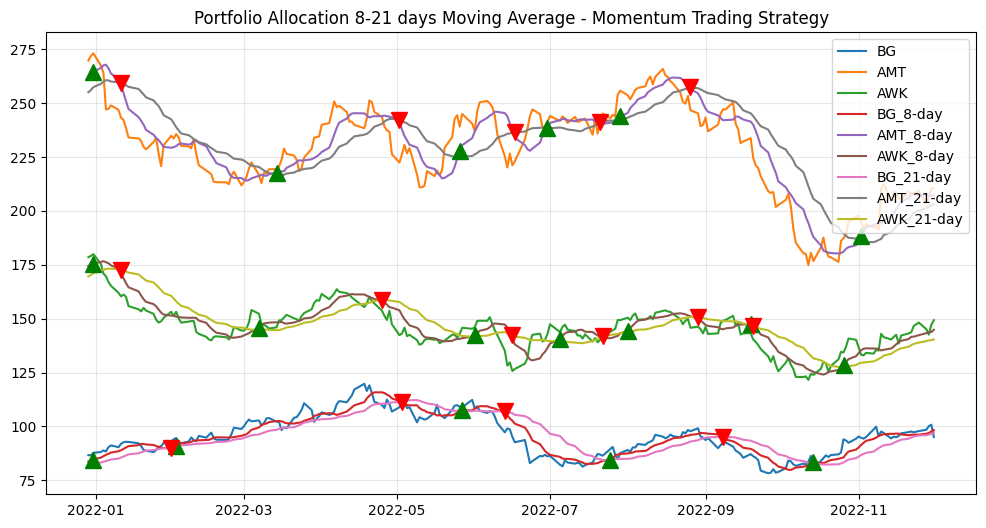

In [ ]:
# imagine where you would put markers on the plot
# for buy vs. sell...
# Visualize the buy and sell point

# the -252: shows the last 252 days
plt.rcParams['figure.figsize'] = 12,6
plt.title('Portfolio Allocation 8-21 days Moving Average - Momentum Trading Strategy')
plt.grid(True, alpha = .3)

# adjusted close price of three stocks
plt.plot(portfolio_data.iloc[-252:]['BG'], label = 'BG') # actual value
plt.plot(portfolio_data.iloc[-252:]['AMT'], label = 'AMT') # actual value
plt.plot(portfolio_data.iloc[-252:]['AWK'], label = 'AWK') # actual value

# three 8-day moving average lines
plt.plot(portfolio_data.iloc[-252:]['BG_8-day'], label = 'BG_8-day') # 8-day average
plt.plot(portfolio_data.iloc[-252:]['AMT_8-day'], label = 'AMT_8-day') # 8-day average
plt.plot(portfolio_data.iloc[-252:]['AWK_8-day'], label = 'AWK_8-day') # 8-day average

# three 21-day moving average lines
plt.plot(portfolio_data.iloc[-252:]['BG_21-day'], label = 'BG_21-day') # 21-day average
plt.plot(portfolio_data.iloc[-252:]['AMT_21-day'], label = 'AMT_21-day') # 21-day average
plt.plot(portfolio_data.iloc[-252:]['AWK_21-day'], label = 'AWK_21-day') # 21-day average

# signals of buying
plt.plot(portfolio_data[-252:].loc[portfolio_data.signal_BG == 1].index, portfolio_data[-252:]['BG_8-day'][portfolio_data.signal_BG == 1], '^',
         color = 'g', markersize = 12)
plt.plot(portfolio_data[-252:].loc[portfolio_data.signal_AMT == 1].index, portfolio_data[-252:]['AMT_8-day'][portfolio_data.signal_AMT == 1], '^',
         color = 'g', markersize = 12)
plt.plot(portfolio_data[-252:].loc[portfolio_data.signal_AWK == 1].index, portfolio_data[-252:]['AWK_8-day'][portfolio_data.signal_AWK == 1], '^',
         color = 'g', markersize = 12)

# signals of selling
plt.plot(portfolio_data[-252:].loc[portfolio_data.signal_BG == -1].index, portfolio_data[-252:]['BG_21-day'][portfolio_data.signal_BG == -1], 'v',
         color = 'r', markersize = 12)
plt.plot(portfolio_data[-252:].loc[portfolio_data.signal_AMT == -1].index, portfolio_data[-252:]['AMT_21-day'][portfolio_data.signal_AMT == -1], 'v',
         color = 'r', markersize = 12)
plt.plot(portfolio_data[-252:].loc[portfolio_data.signal_AWK == -1].index, portfolio_data[-252:]['AWK_21-day'][portfolio_data.signal_AWK == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=0);

## 3.3 - Momentum trading strategy for the entire MPT portfolio

### 3.3.1 Getting data and create columns

In [ ]:
# Assign the ticker list that we want to scrap
tickers5 = ['BG','AMT','AWK']
portfolio1 = {ticker : si.get_data(ticker,start_date = '11/29/2021',end_date='12/02/2022',interval='1d') for ticker in tickers5}
entire_portfolio = pd.DataFrame(portfolio1['BG']['adjclose']).rename(columns = {"adjclose":"BG"})
# combine all the tickers (all the rest of the samples)
for i in tickers_list_portfolio[0:]:
  entire_portfolio[i] = pd.DataFrame(portfolio1[i]['adjclose'])

# rolled back (no data leakage)
# for loop with f-string embedding expressions inside string literals
for x in ['BG','AMT','AWK']:
  entire_portfolio[f'{x}_8-day'] = entire_portfolio[f'{x}'].rolling(8).mean().shift() # data will be shift after by one
  entire_portfolio[f'{x}_21-day'] = entire_portfolio[f'{x}'].rolling(21).mean().shift()

# drop nulls
entire_portfolio.dropna(inplace=True)
# check work
entire_portfolio

,BG,AMT,AWK,BG_8-day,BG_21-day,AMT_8-day,AMT_21-day,AWK_8-day,AWK_21-day
2021-12-29,86.687721,269.789062,178.534836,83.715782,82.513616,261.727165,255.084704,174.483278,169.607606
2021-12-30,86.546684,271.899750,179.144592,84.178789,82.586586,262.986923,256.119093,175.014433,170.245945
2021-12-31,87.768845,273.169830,179.935364,84.646494,82.832358,264.581371,257.451356,175.600372,171.128823
2022-01-03,88.097885,267.454254,175.438400,85.532549,83.229444,266.381054,259.000310,176.343513,172.084291
2022-01-04,88.868782,264.082825,170.941452,86.171826,83.572361,267.537151,259.954497,176.685312,172.709020
...,...,...,...,...,...,...,...,...,...
2022-11-25,97.843063,209.381485,148.206375,96.178336,95.790923,207.244396,200.186970,142.315445,138.905671
2022-11-28,98.419861,203.501862,145.153076,96.603905,95.973514,207.803341,201.236216,143.302921,139.567374
2022-11-29,100.131012,206.660492,142.623199,96.994104,96.208591,207.127855,201.925744,143.754856,139.955050
2022-11-30,100.784698,210.494568,147.101349,97.639991,96.575190,206.898335,202.492501,143.765762,140.042172


In [ ]:
# for loop with f-strings to create return columns
for x in ['BG','AMT','AWK']:
  entire_portfolio[f'return_{x}'] = entire_portfolio[f'{x}'].pct_change()

entire_portfolio.head()

,BG,AMT,AWK,BG_8-day,BG_21-day,AMT_8-day,AMT_21-day,AWK_8-day,AWK_21-day,return_BG,return_AMT,return_AWK
2021-12-29,86.687721,269.789062,178.534836,83.715782,82.513616,261.727165,255.084704,174.483278,169.607606,NaN,NaN,NaN
2021-12-30,86.546684,271.899750,179.144592,84.178789,82.586586,262.986923,256.119093,175.014433,170.245945,-0.001627,0.007823,0.003415
2021-12-31,87.768845,273.169830,179.935364,84.646494,82.832358,264.581371,257.451356,175.600372,171.128823,0.014121,0.004671,0.004414
2022-01-03,88.097885,267.454254,175.438400,85.532549,83.229444,266.381054,259.000310,176.343513,172.084291,0.003749,-0.020923,-0.024992
2022-01-04,88.868782,264.082825,170.941452,86.171826,83.572361,267.537151,259.954497,176.685312,172.709020,0.008750,-0.012606,-0.025633


In [ ]:
# This part is a contingency plan
for stock in ['BG', 'AMT', 'AWK']:
    entire_portfolio.loc["2021-12-29", f'return_{stock}'] = 0.0

for stock in ['BG', 'AMT', 'AWK']:
    entire_portfolio.loc["2021-12-30", f'return_{stock}'] = 0.0

# 01-01-2022 stock market is not open, so for now we force the buy-in date to be 12-31-2021, subject to Professor's confirmation
for stock in ['BG', 'AMT', 'AWK']:
    entire_portfolio.loc["2021-12-31", f'return_{stock}'] = 0.0

# the np.where() function is similar to the Excel =IF() statement
# f-string comes in handy in our project!
for stock in ['BG', 'AMT', 'AWK']:
    entire_portfolio[f'invested_{stock}'] = np.where(entire_portfolio[f'{stock}_8-day'] > entire_portfolio[f'{stock}_21-day'], 1, 0)

In [ ]:
entire_portfolio.head()

,BG,AMT,AWK,BG_8-day,BG_21-day,AMT_8-day,AMT_21-day,AWK_8-day,AWK_21-day,return_BG,return_AMT,return_AWK,invested_BG,invested_AMT,invested_AWK
2021-12-29,86.687721,269.789062,178.534836,83.715782,82.513616,261.727165,255.084704,174.483278,169.607606,0.000000,0.000000,0.000000,1,1,1
2021-12-30,86.546684,271.899750,179.144592,84.178789,82.586586,262.986923,256.119093,175.014433,170.245945,0.000000,0.000000,0.000000,1,1,1
2021-12-31,87.768845,273.169830,179.935364,84.646494,82.832358,264.581371,257.451356,175.600372,171.128823,0.000000,0.000000,0.000000,1,1,1
2022-01-03,88.097885,267.454254,175.438400,85.532549,83.229444,266.381054,259.000310,176.343513,172.084291,0.003749,-0.020923,-0.024992,1,1,1
2022-01-04,88.868782,264.082825,170.941452,86.171826,83.572361,267.537151,259.954497,176.685312,172.709020,0.008750,-0.012606,-0.025633,1,1,1


In [ ]:
# the variable signal tells you when you buy and sell
# nested for loop with if-elif
for x in ['BG', 'AMT', 'AWK']:
    # this layer creates signal_stock column with 1s and 0s
    entire_portfolio[f'signal_{x}'] = entire_portfolio[f'invested_{x}'].diff()
    # since signal calculates the difference from previous day, so the first record is null, we change to 0 for data quality
    for date in ["2021-12-29", "2021-12-31"]:
        if date == "2021-12-29":
            entire_portfolio.loc[date, f'signal_{x}'] = 0
        # the first buy-in point is currently 2021-12-31, even though the first record is 2021-12-29, subject to professors confirmation
        elif date == "2021-12-31":
            entire_portfolio.loc[date, f'signal_{x}'] = 1

entire_portfolio.head()

,BG,AMT,AWK,BG_8-day,BG_21-day,AMT_8-day,AMT_21-day,AWK_8-day,AWK_21-day,return_BG,return_AMT,return_AWK,invested_BG,invested_AMT,invested_AWK,signal_BG,signal_AMT,signal_AWK
2021-12-29,86.687721,269.789062,178.534836,83.715782,82.513616,261.727165,255.084704,174.483278,169.607606,0.000000,0.000000,0.000000,1,1,1,0.0,0.0,0.0
2021-12-30,86.546684,271.899750,179.144592,84.178789,82.586586,262.986923,256.119093,175.014433,170.245945,0.000000,0.000000,0.000000,1,1,1,0.0,0.0,0.0
2021-12-31,87.768845,273.169830,179.935364,84.646494,82.832358,264.581371,257.451356,175.600372,171.128823,0.000000,0.000000,0.000000,1,1,1,1.0,1.0,1.0
2022-01-03,88.097885,267.454254,175.438400,85.532549,83.229444,266.381054,259.000310,176.343513,172.084291,0.003749,-0.020923,-0.024992,1,1,1,0.0,0.0,0.0
2022-01-04,88.868782,264.082825,170.941452,86.171826,83.572361,267.537151,259.954497,176.685312,172.709020,0.008750,-0.012606,-0.025633,1,1,1,0.0,0.0,0.0


### 3.3.2 Def function to set buy and sell portfolio signal

In [ ]:
# when any of 3 stocks signal a sell or a buy, we buy and sell all the stocks
def signal(entire_portfolio):
    # add a new column to store signals
    signal_portfolio = []
    flag = 0  # initiate flag to 0
    for i in range(0, len(entire_portfolio)):
        if (entire_portfolio['signal_BG'][i] + entire_portfolio['signal_AMT'][i] + entire_portfolio['signal_AWK'][i] >= 1 ) and flag == 0:
            signal_portfolio.append('1')
            flag = 1  # when a buy signal triggered, flag set to 1
        elif( entire_portfolio['signal_BG'][i] + entire_portfolio['signal_AMT'][i] + entire_portfolio['signal_AWK'][i] < 0 ) and flag == 1:
            signal_portfolio.append('-1')
            flag = 0  # when sell signal triggered, flag set back to 0
        else:
            # append 0 even if there is another buy signal after last purchase because flag was set to 1, it will be set to 0 after a sell.
            signal_portfolio.append('0')
    return signal_portfolio

# apply def function to entire_portfolio
sig = signal(entire_portfolio)
entire_portfolio['signal_portfolio'] = sig

# check work
entire_portfolio.head(20)

,BG,AMT,AWK,BG_8-day,BG_21-day,AMT_8-day,AMT_21-day,AWK_8-day,AWK_21-day,return_BG,return_AMT,return_AWK,invested_BG,invested_AMT,invested_AWK,signal_BG,signal_AMT,signal_AWK,signal_portfolio
2021-12-29,86.687721,269.789062,178.534836,83.715782,82.513616,261.727165,255.084704,174.483278,169.607606,0.000000,0.000000,0.000000,1,1,1,0.0,0.0,0.0,0
2021-12-30,86.546684,271.899750,179.144592,84.178789,82.586586,262.986923,256.119093,175.014433,170.245945,0.000000,0.000000,0.000000,1,1,1,0.0,0.0,0.0,0
2021-12-31,87.768845,273.169830,179.935364,84.646494,82.832358,264.581371,257.451356,175.600372,171.128823,0.000000,0.000000,0.000000,1,1,1,1.0,1.0,1.0,1
2022-01-03,88.097885,267.454254,175.438400,85.532549,83.229444,266.381054,259.000310,176.343513,172.084291,0.003749,-0.020923,-0.024992,1,1,1,0.0,0.0,0.0,0
2022-01-04,88.868782,264.082825,170.941452,86.171826,83.572361,267.537151,259.954497,176.685312,172.709020,0.008750,-0.012606,-0.025633,1,1,1,0.0,0.0,0.0,0
2022-01-05,88.342316,247.085587,169.683853,86.821680,83.926469,267.876862,260.716277,176.214895,173.062443,-0.005924,-0.064363,-0.007357,1,1,1,0.0,0.0,0.0,0
2022-01-06,90.363548,247.384445,167.016129,87.269408,84.258195,266.222670,260.553164,175.740910,173.252085,0.022880,0.001210,-0.015722,1,1,1,0.0,0.0,0.0,0
2022-01-07,91.209641,248.962723,165.301178,87.864030,84.631553,263.786324,260.083896,174.754816,173.196734,0.009363,0.006380,-0.010268,1,1,1,0.0,0.0,0.0,0
2022-01-10,90.354149,246.936188,161.995178,88.485678,85.079225,261.228559,259.732264,173.249475,173.048832,-0.009379,-0.008140,-0.020000,1,1,1,0.0,0.0,0.0,0
2022-01-11,91.905342,243.275192,160.356461,88.943981,85.555101,258.371950,259.496102,171.182018,172.786147,0.017168,-0.014826,-0.010116,1,0,0,0.0,-1.0,-1.0,-1


### 3.3.3 Def function to generate invested column for portfolio

In [ ]:
# creating
def invested(entire_portfolio):
    if 'signal_portfolio' not in entire_portfolio.columns:
        raise ValueError("The 'signal_portfolio' column does not exist in the DataFrame")

    invested_portfolio = []
    current_val = 1
    for i in range(0, len(entire_portfolio)):
        if entire_portfolio['signal_portfolio'][i] == '1':
            current_val = 1
            invested_portfolio.append(current_val)
        elif entire_portfolio['signal_portfolio'][i] == '-1':
            current_val = 0
            invested_portfolio.append(current_val)
        else:
            invested_portfolio.append(current_val)
    return invested_portfolio

inv = invested(entire_portfolio)
entire_portfolio['invested_portfolio'] = inv
entire_portfolio

,BG,AMT,AWK,BG_8-day,BG_21-day,AMT_8-day,AMT_21-day,AWK_8-day,AWK_21-day,return_BG,return_AMT,return_AWK,invested_BG,invested_AMT,invested_AWK,signal_BG,signal_AMT,signal_AWK,signal_portfolio,invested_portfolio
2021-12-29,86.687721,269.789062,178.534836,83.715782,82.513616,261.727165,255.084704,174.483278,169.607606,0.000000,0.000000,0.000000,1,1,1,0.0,0.0,0.0,0,1
2021-12-30,86.546684,271.899750,179.144592,84.178789,82.586586,262.986923,256.119093,175.014433,170.245945,0.000000,0.000000,0.000000,1,1,1,0.0,0.0,0.0,0,1
2021-12-31,87.768845,273.169830,179.935364,84.646494,82.832358,264.581371,257.451356,175.600372,171.128823,0.000000,0.000000,0.000000,1,1,1,1.0,1.0,1.0,1,1
2022-01-03,88.097885,267.454254,175.438400,85.532549,83.229444,266.381054,259.000310,176.343513,172.084291,0.003749,-0.020923,-0.024992,1,1,1,0.0,0.0,0.0,0,1
2022-01-04,88.868782,264.082825,170.941452,86.171826,83.572361,267.537151,259.954497,176.685312,172.709020,0.008750,-0.012606,-0.025633,1,1,1,0.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,97.843063,209.381485,148.206375,96.178336,95.790923,207.244396,200.186970,142.315445,138.905671,0.005930,0.008385,0.010842,1,1,1,0.0,0.0,0.0,0,1
2022-11-28,98.419861,203.501862,145.153076,96.603905,95.973514,207.803341,201.236216,143.302921,139.567374,0.005895,-0.028081,-0.020602,1,1,1,0.0,0.0,0.0,0,1
2022-11-29,100.131012,206.660492,142.623199,96.994104,96.208591,207.127855,201.925744,143.754856,139.955050,0.017386,0.015521,-0.017429,1,1,1,0.0,0.0,0.0,0,1
2022-11-30,100.784698,210.494568,147.101349,97.639991,96.575190,206.898335,202.492501,143.765762,140.042172,0.006528,0.018553,0.031398,1,1,1,0.0,0.0,0.0,0,1


In [ ]:
# cumulative return for the portfolio
for x in ['BG', 'AMT', 'AWK']:
  entire_portfolio[f'system_return_{x}'] = entire_portfolio[f'return_{x}'] * entire_portfolio['invested_portfolio']
  entire_portfolio[f's_cumprod_{x}'] = (entire_portfolio[f'system_return_{x}']+1).cumprod()-1

In [ ]:
# Bringing in the porportion of each stock that consists of our portfolio and our total investment
BG_allocation = 0.179 # allocation of BG
AMT_allocation = 0.411 # allocation of AMT
AWK_allocation = 0.41 # allocation of AWK
total_amt = 100000 # total investment

# create the daily money amount volatility columns of each stock
entire_portfolio['aggVal_BG'] = BG_allocation * total_amt * (entire_portfolio['s_cumprod_BG']+1)
entire_portfolio['aggVal_AMT'] = AMT_allocation * total_amt * (entire_portfolio['s_cumprod_AMT']+1)
entire_portfolio['aggVal_AWK'] = AWK_allocation * total_amt * (entire_portfolio['s_cumprod_AWK']+1)

# create the aggregate value columns of portfolio
entire_portfolio['aggVal_portfolio'] = entire_portfolio['aggVal_BG'] + entire_portfolio['aggVal_AMT'] + entire_portfolio['aggVal_AWK']

# create return for whole portfolio
entire_portfolio['return_portfolio'] = entire_portfolio['aggVal_portfolio'].pct_change()
entire_portfolio.loc['2021-12-29','return_portfolio'] = 0

entire_portfolio.head()

,BG,AMT,AWK,BG_8-day,BG_21-day,AMT_8-day,AMT_21-day,AWK_8-day,AWK_21-day,return_BG,...,s_cumprod_BG,system_return_AMT,s_cumprod_AMT,system_return_AWK,s_cumprod_AWK,aggVal_BG,aggVal_AMT,aggVal_AWK,aggVal_portfolio,return_portfolio
2021-12-29,86.687721,269.789062,178.534836,83.715782,82.513616,261.727165,255.084704,174.483278,169.607606,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,17900.000000,41100.000000,41000.000000,100000.000000,0.000000
2021-12-30,86.546684,271.899750,179.144592,84.178789,82.586586,262.986923,256.119093,175.014433,170.245945,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,17900.000000,41100.000000,41000.000000,100000.000000,0.000000
2021-12-31,87.768845,273.169830,179.935364,84.646494,82.832358,264.581371,257.451356,175.600372,171.128823,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,17900.000000,41100.000000,41000.000000,100000.000000,0.000000
2022-01-03,88.097885,267.454254,175.438400,85.532549,83.229444,266.381054,259.000310,176.343513,172.084291,0.003749,...,0.003749,-0.020923,-0.020923,-0.024992,-0.024992,17967.106107,40240.058108,39975.323696,98182.487911,-0.018175
2022-01-04,88.868782,264.082825,170.941452,86.171826,83.572361,267.537151,259.954497,176.685312,172.709020,0.008750,...,0.012532,-0.012606,-0.033265,-0.025633,-0.049984,18124.326528,39732.806813,38950.650868,96807.784210,-0.014002


### 3.3.4 Aggregate Value on the first day of each month - Momentum trading for entire portfolio

In [ ]:
# reset index and name it date
entire_portfolio.reset_index()
df3 = entire_portfolio.rename(columns={'index': 'date'})

# subset the first day of each month
portfolio_FirstDay_Month3 = df3.resample('MS').first()

# create a table showing the aggregate value of the whole porfolio
portfolio_FirstDay_Month3 = portfolio_FirstDay_Month3.drop(columns=portfolio_FirstDay_Month3.columns.difference(['aggVal_portfolio']))
portfolio_FirstDay_Month3
# for buy and hold case, amount of money invested on the first day of each month equals to aggregate value on the first day

,aggVal_portfolio
2021-12-01,100000.000000
2022-01-01,98182.487911
2022-02-01,92492.410788
2022-03-01,88818.289441
2022-04-01,98477.095353
2022-05-01,99292.775864
2022-06-01,99136.492826
2022-07-01,99286.119897
2022-08-01,99989.529084
2022-09-01,101937.795012


In [ ]:
print((entire_portfolio['aggVal_BG'].pct_change()+1).cumprod()[-1]-1)

0.44977209049264943


In [ ]:
#return of selling stock
print((entire_portfolio['return_portfolio']+1).cumprod()[-1]-1)

0.19585691056124777


## 3.4 - Buy-and-Hold strategy for the S&P 500 index

In [ ]:
# ticker = amt, Bunge Limited
ticker4= '^GSPC'
GSPC_prices = si.get_data(ticker4,start_date = '12/29/2021',end_date='12/02/2022',interval='1d')

# We only need the adjusted close price
GSPC_prices.drop(columns=['open', 'high','low','close','volume','ticker'], inplace = True)

# change the sequence or columns
GSPC_prices = GSPC_prices[['adjclose']]

# rename the columns
GSPC_prices.columns = ['GSPC']

# check our work
GSPC_prices.head()

GSPC_prices['return'] = GSPC_prices['GSPC'].pct_change()

GSPC_prices.loc["2021-12-29",'return'] = 0.0
GSPC_prices.loc["2021-12-30",'return'] = 0.0
GSPC_prices.loc["2021-12-31",'return'] = 0.0
GSPC_prices.head()

,GSPC,return
2021-12-29,4793.060059,0.000000
2021-12-30,4778.729980,0.000000
2021-12-31,4766.180176,0.000000
2022-01-03,4796.560059,0.006374
2022-01-04,4793.540039,-0.000630


In [ ]:
# Bringing in the porportion of each stock that consists of our portfolio and our total investment
total_amt = 100000 # total investment

# create the daily money amount volatility columns of each stock
GSPC_prices['r_cumprod_GSPC'] = (GSPC_prices['return']+1).cumprod()-1

# create the aggregate value columns of each stock
GSPC_prices['aggVal_GSPC'] = (GSPC_prices['r_cumprod_GSPC']+1) * total_amt

# check work
GSPC_prices.head()

,GSPC,return,r_cumprod_GSPC,aggVal_GSPC
2021-12-29,4793.060059,0.000000,0.000000,100000.000000
2021-12-30,4778.729980,0.000000,0.000000,100000.000000
2021-12-31,4766.180176,0.000000,0.000000,100000.000000
2022-01-03,4796.560059,0.006374,0.006374,100637.405253
2022-01-04,4793.540039,-0.000630,0.005740,100574.041733


In [ ]:
# reset index and name it date
GSPC_prices.reset_index()
df4 = GSPC_prices.rename(columns={'index': 'date'})

# subset the first day of each month
data_FirstDay_Month3 = df4.resample('MS').first()
# create a table showing the aggregate value of the whole porfolio
data_FirstDay_Month3= data_FirstDay_Month3.drop(columns=data_FirstDay_Month3.columns.difference(['aggVal_GSPC']))
data_FirstDay_Month3
# for buy and hold case, amount of money invested on the first day of each month equals to aggregate value on the first day

,aggVal_GSPC
2021-12-01,100000.000000
2022-01-01,100637.405253
2022-02-01,95391.694636
2022-03-01,90350.335212
2022-04-01,95377.423757
2022-05-01,87184.699897
2022-06-01,86048.572005
2022-07-01,80259.871365
2022-08-01,86413.642181
2022-09-01,83229.125869


In [ ]:
print((GSPC_prices['return']+1).cumprod()[-1]-1)

-0.14468821613711602


## 3.5 - Plot Comparing the Investment Strategies

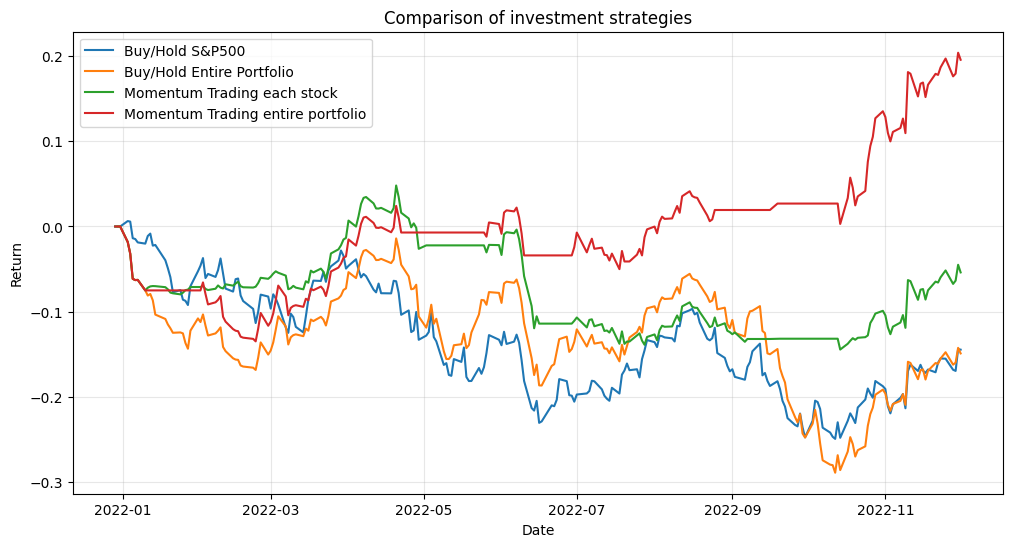

In [ ]:
# this is just comparing BG with S&P 500
plt.plot((GSPC_prices['return']+1).cumprod()-1, label='Buy/Hold S&P500 ')
plt.plot((BAH_data['return_portfolio']+1).cumprod()-1, label = 'Buy/Hold Entire Portfolio')
plt.plot((portfolio_data['return_portfolio']+1).cumprod()-1, label='Momentum Trading each stock') # Momentum trading of BG in porfolio
plt.plot((entire_portfolio['return_portfolio']+1).cumprod()-1, label='Momentum Trading entire portfolio')
plt.title('Comparison of investment strategies')
xlabel('Date')
ylabel('Return')
plt.legend(loc=2)
plt.grid(True, alpha=.3)
plt.show()

## 3.6 - Discussion and Comparison of the Investment Strategies

These are our total return.

Buy/Hold Entire Portfilio : -0.14909502161679422
, This suggests that the overall portfolio value decreased over the specified period.

Momentum Trading Entire Portfolio: 0.19585739838415717, This indicates that the portfolio generated a profit, and the momentum trading strategy was successful in capturing positive price movements.

Buy/Hold S&P 500: -0.14468821613711602, This indicates that investing solely in the S&P 500 index yielded a loss over the specified period.

Also, In the above graph, Rate of Return of Momentum Trading Entire Portfolio increases more than other graphs. Therefore, we can use Momentum Trading Entire Portfolio stategy for our investment.


# 4 - Conclusion

## 4.1 - Thoughts and Insights

* This research assists in identifying which strategy was more effective at collecting market gains or at reducing losses.

* Diversification of a portfolio is emphasized by MPT. A diversified portfolio's performance using various strategies can be examined via the project. This analysis can shed light on whether combining various assets improved or hampered the effectiveness of each strategy.

* Portfolio helpes ensure that investments are tailored to our unique circumstances and objectives, increasing the likelihood of achieving our desired investment outcomes.   

* Risk diversification in the portfolio is aided by choosing the risk level. Instead of investing in a single asset, diversifying the risk by mixing several assets into a portfolio helps lessen the impact of potential losses from a single investment. The overall stability of the portfolio is improved through risk diversification.

* Finding a balance between prospective returns and related hazards is necessary when determining the risk level. Portfolios with a higher level of risk may have larger potential profits but also higher potential losses. While potentially offering lower growth, lower-risk portfolios typically offer more consistent returns. Finding the ideal balance that complements the investor's objectives and risk tolerance is key.





